# Sebastian Schwab

#### EE 399 5/22/23
Github: https://github.com/sebschwab/ML-Training/tree/main/project%206

### SHRED applied to SST dataset

This iPython notebook gives an introductory walkthrough to using SHRED models.  The dataset we consider is weekly mean sea-surface temperature as given by the NOAA Optimum Interpolation SST V2 dataset (https://psl.noaa.gov/data/gridded/data.noaa.oisst.v2.html).

SHRED (SHallow REcurrent Decoder) models are a network architecture that merges a recurrent layer (LSTM) with a shallow decoder network (SDN) to reconstruct high-dimensional spatio-temporal fields from a trajectory of sensor measurements of the field. More formally, the SHRED architecture can be written as 
$$ \mathcal {H} \left( \{ y_i \} _{i=t-k}^t \right) = \mathcal {F} \left( \mathcal {G} \left( \{ y_i \} _{i=t-k}^t \right) ; W_{RN}) ; W_{SD} \right)$$
where $\mathcal F$ is a feed forward network parameterized by weights $W_{SD}$, $\mathcal G$ is a LSTM network parameterized by weights $W_{RN}$, and $\{ y_i \} _{i=t-k}^t$ is a trajectory of sensor measurements of a high-dimensional spatio-temporal field $\{ x_i \} _{i=t-k}^t$.

We first randomly select 3 sensor locations and set the trajectory length (lags) to 52, corresponding to one year of measurements.

In [1]:
import numpy as np
from processdata import load_data
from processdata import TimeSeriesDataset
import models
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

num_sensors = 3 
lags = 52
load_X = load_data('SST')
n = load_X.shape[0]
m = load_X.shape[1]
sensor_locations = np.random.choice(m, size=num_sensors, replace=False)

We now select indices to divide the data into training, validation, and test sets.

In [3]:
train_indices = np.random.choice(n - lags, size=1000, replace=False)
mask = np.ones(n - lags)
mask[train_indices] = 0
valid_test_indices = np.arange(0, n - lags)[np.where(mask!=0)[0]]
valid_indices = valid_test_indices[::2]
test_indices = valid_test_indices[1::2]

sklearn's MinMaxScaler is used to preprocess the data for training and we generate input/output pairs for the training, validation, and test sets. 

In [4]:
sc = MinMaxScaler()
sc = sc.fit(load_X[train_indices])
transformed_X = sc.transform(load_X)

### Generate input sequences to a SHRED model
all_data_in = np.zeros((n - lags, lags, num_sensors))
for i in range(len(all_data_in)):
    all_data_in[i] = transformed_X[i:i+lags, sensor_locations]

### Generate training validation and test datasets both for rec onstruction of states and forecasting sensors
device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

### -1 to have output be at the same time as final sensor measurements
train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
test_data_out = torch.tensor(transformed_X[test_indices + lags - 1], dtype=torch.float32).to(device)

train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

We train the model using the training and validation datasets.

In [6]:
shred = models.SHRED(num_sensors, m, hidden_size=64, hidden_layers=2, l1=350, l2=400, dropout=0.1).to(device)
validation_errors = models.fit(shred, train_dataset, valid_dataset, batch_size=64, num_epochs=1000, lr=1e-3, verbose=True, patience=5)

Training epoch 1
Error tensor(0.4713)
Training epoch 20
Error tensor(0.2296)
Training epoch 40
Error tensor(0.2210)
Training epoch 60
Error tensor(0.2198)
Training epoch 80
Error tensor(0.2167)
Training epoch 100
Error tensor(0.2023)
Training epoch 120
Error tensor(0.1954)
Training epoch 140
Error tensor(0.1930)
Training epoch 160
Error tensor(0.1862)
Training epoch 180
Error tensor(0.1773)
Training epoch 200
Error tensor(0.1705)
Training epoch 220
Error tensor(0.1609)
Training epoch 240
Error tensor(0.1506)
Training epoch 260
Error tensor(0.1431)
Training epoch 280
Error tensor(0.1365)
Training epoch 300
Error tensor(0.1293)
Training epoch 320
Error tensor(0.1246)
Training epoch 340
Error tensor(0.1252)
Training epoch 360
Error tensor(0.1194)
Training epoch 380
Error tensor(0.1176)
Training epoch 400
Error tensor(0.1163)
Training epoch 420
Error tensor(0.1191)
Training epoch 440
Error tensor(0.1160)
Training epoch 460
Error tensor(0.1157)
Training epoch 480
Error tensor(0.1136)
Traini

Finally, we generate reconstructions from the test set and print mean square error compared to the ground truth.

In [7]:
test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
print(np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth))

0.01955256


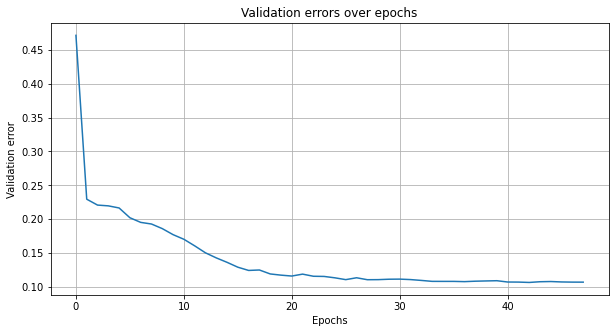

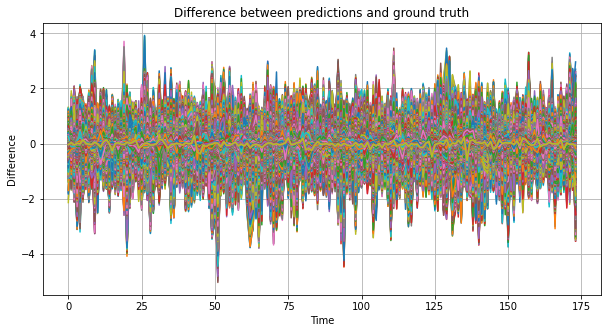

In [8]:
import matplotlib.pyplot as plt

# Plot validation errors
plt.figure(figsize=(10, 5))
plt.plot(validation_errors)
plt.title("Validation errors over epochs")
plt.xlabel("Epochs")
plt.ylabel("Validation error")
plt.grid(True)
plt.show()

# Plot difference between predicted and actual test data
diff = test_recons - test_ground_truth
plt.figure(figsize=(10, 5))
plt.plot(diff)
plt.title("Difference between predictions and ground truth")
plt.xlabel("Time")
plt.ylabel("Difference")
plt.grid(True)
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# List of lags to test
lag_list = [10, 20, 30, 40, 50, 60]

# Initialize an empty list to store the results
results = []

# Loop over the lags
for lags in lag_list:

    # Code to prepare data (similar to the previous code you've shown, but replace "52" with "lags")
    all_data_in = np.zeros((n - lags, lags, num_sensors))
    for i in range(len(all_data_in)):
        all_data_in[i] = transformed_X[i:i+lags, sensor_locations]

    # Code to train model and calculate error on test data
    ### Generate training validation and test datasets both for rec onstruction of states and forecasting sensors
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
    valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
    test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

    ### -1 to have output be at the same time as final sensor measurements
    train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
    valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
    test_data_out = torch.tensor(transformed_X[test_indices + lags - 1], dtype=torch.float32).to(device)

    train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
    valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
    test_dataset = TimeSeriesDataset(test_data_in, test_data_out)
    
    shred1 = models.SHRED(num_sensors, m, hidden_size=64, hidden_layers=2, l1=350, l2=400, dropout=0.1).to(device)
    validation_errors1 = models.fit(shred1, train_dataset, valid_dataset, batch_size=64, num_epochs=10, lr=0.1, verbose=True, patience=5)
    test_recons1 = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
    test_ground_truth1 = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
    
    # Save error
    error = np.linalg.norm(test_recons1 - test_ground_truth1) / np.linalg.norm(test_ground_truth1)
    results.append(error)

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(lag_list, results, marker='o')
plt.title("Model performance as a function of time lag")
plt.xlabel("Time lag")
plt.ylabel("Error")
plt.grid(True)
plt.show()


In [16]:
# ADDING NOISE

# List of standard deviations for the Gaussian noise
std_devs = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]

# Load and prepare initial data
num_sensors = 3 
load_X = load_data('SST')
n = load_X.shape[0]
m = load_X.shape[1]
sensor_locations = np.random.choice(m, size=num_sensors, replace=False)
train_indices = np.random.choice(n - 52, size=1000, replace=False)
mask = np.ones(n - 52)
mask[train_indices] = 0
valid_test_indices = np.arange(0, n - 52)[np.where(mask!=0)[0]]
valid_indices = valid_test_indices[::2]
test_indices = valid_test_indices[1::2]
sc = MinMaxScaler()
sc = sc.fit(load_X[train_indices])
transformed_X = sc.transform(load_X)

# Initialize an empty list to store the results
results = []

# Loop over the standard deviations
for std_dev in std_devs:
    # Add Gaussian noise to the data
    noisy_X = transformed_X + np.random.normal(loc=0, scale=std_dev, size=transformed_X.shape)

    # Prepare data for current standard deviation
    all_data_in = np.zeros((n - 52, 52, num_sensors))
    for i in range(len(all_data_in)):
        all_data_in[i] = noisy_X[i:i+52, sensor_locations]

    # Prepare datasets
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
    valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
    test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

    train_data_out = torch.tensor(noisy_X[train_indices + 52 - 1], dtype=torch.float32).to(device)
    valid_data_out = torch.tensor(noisy_X[valid_indices + 52 - 1], dtype=torch.float32).to(device)
    test_data_out = torch.tensor(noisy_X[test_indices + 52 - 1], dtype=torch.float32).to(device)

    train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
    valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
    test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

    # Create and train the model
    shred = models.SHRED(num_sensors, m, hidden_size=64, hidden_layers=2, l1=350, l2=400, dropout=0.1).to(device)

    validation_errors = models.fit(shred, train_dataset, valid_dataset, batch_size=64, num_epochs=1000, lr=1e-3, verbose=True, patience=5)

    # Calculate error
    test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
    test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())

    error = np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth)
    results.append(error)

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(std_devs, results, marker='o')
plt.title("Model performance as a function of noise standard deviation")
plt.xlabel("Standard deviation of noise")
plt.ylabel("Error")
plt.grid(True)
plt.show()


Training epoch 1
Error tensor(0.4762)
Training epoch 20
Error tensor(0.2215)
Training epoch 40
Error tensor(0.2136)


KeyboardInterrupt: 

In [ ]:
# Testing different numbers of sensors

# List of sensors to test
sensor_list = [2, 3, 4, 5, 6, 7, 8, 9, 10]

# Load and prepare initial data
load_X = load_data('SST')
n = load_X.shape[0]
m = load_X.shape[1]
train_indices = np.random.choice(n - 52, size=1000, replace=False)
mask = np.ones(n - 52)
mask[train_indices] = 0
valid_test_indices = np.arange(0, n - 52)[np.where(mask!=0)[0]]
valid_indices = valid_test_indices[::2]
test_indices = valid_test_indices[1::2]
sc = MinMaxScaler()
sc = sc.fit(load_X[train_indices])
transformed_X = sc.transform(load_X)

# Initialize an empty list to store the results
results = []

# Loop over the sensor list
for num_sensors in sensor_list:
    # Randomly choose sensor locations
    sensor_locations = np.random.choice(m, size=num_sensors, replace=False)

    # Prepare data for current number of sensors
    all_data_in = np.zeros((n - 52, 52, num_sensors))
    for i in range(len(all_data_in)):
        all_data_in[i] = transformed_X[i:i+52, sensor_locations]

    # Prepare datasets
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
    valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
    test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

    train_data_out = torch.tensor(transformed_X[train_indices + 52 - 1, sensor_locations], dtype=torch.float32).to(device)
    valid_data_out = torch.tensor(transformed_X[valid_indices + 52 - 1, sensor_locations], dtype=torch.float32).to(device)
    test_data_out = torch.tensor(transformed_X[test_indices + 52 - 1, sensor_locations], dtype=torch.float32).to(device)

    train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
    valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
    test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

    # Create and train the model
    shred = models.SHRED(num_sensors, m, hidden_size=64, hidden_layers=2, l1=350, l2=400, dropout=0.1).to(device)
    validation_errors = models.fit(shred, train_dataset, valid_dataset, batch_size=64, num_epochs=1000, lr=1e-3, verbose=True, patience=5)

    # Calculate error
    test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
    test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())

    error = np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth)
    results.append(error)
    
    # Plot the results
plt.figure(figsize=(10, 5))
plt.plot(sensor_list, results, marker='o')
plt.title("Model performance as a function of number of sensors")
plt.xlabel("Number of sensors")
plt.ylabel("Error")
plt.grid(True)
plt.show()
